# Factor Analysis

Factor analysis is a method for automatically finding latent variables in a data set. It assumes that observed variables are actually a linear combination of a number of latent factors. Often, we are aiming to find a smaller number of factors that explain trends in our data.

This is how factor analysis differs from principal componant analysis. In PCA, the components are not interpretable, however, in factor analysis, we can see which observed variables are highly correlated with which factors and group observed variables according to which factors they are correlated with by looking at the loading. We can also see which factors are most important by their eiganvalues. Another technical difference between PCA and factor analysis is that in PCA, all the components are orthogonal but in factor analysis this does not need to be the case.

## Load Data

In [1]:
import pandas as pd
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo
from scipy.stats import pointbiserialr
import matplotlib.pyplot as plt

In [2]:
wellness_df = pd.read_csv('./raw_data/wellness.csv')
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,BedTime,WakeTime,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,23:00:00,07:00:00,8.00,2,13,No,No,Yes,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,23:00:00,07:00:00,8.00,4,19,Yes,No,Yes,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,22:30:00,06:30:00,8.00,4,19,No,No,No,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,00:30:00,07:00:00,6.50,1,15,No,No,Yes,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,23:45:00,07:00:00,7.25,4,20,No,No,No,Okay,Yes,Yes,1.022,100%


In [3]:
wellness_df.shape

(5011, 19)

To start with, we have 5011 wellness observations.

## Cleaning Data

### Fatigue

In [4]:
wellness_df['Fatigue'].value_counts()

4    2003
3    1721
2     642
5     301
1     187
6     150
7       7
Name: Fatigue, dtype: int64

Based on the codebook, 1 is most tired and 7 is most fresh. The scales are:
1 -> Exhausted
4 -> Average
7 -> Fresher than usual

Thus, the values above make sense with average being most common and 1 less than average being second most common. I think we should be good leaving the values as is here.

### Soreness, Desire and Irritability

All of these columns are on the same scale as fatigue so we just need to make sure there are no missing values and we can continue using the raw values as with Fatigue.

In [5]:
wellness_df['Soreness'].value_counts()

4    1843
3    1831
2     737
5     280
1     176
6     128
7      16
Name: Soreness, dtype: int64

In [6]:
wellness_df['Desire'].value_counts()

4    3023
3     820
5     428
2     300
6     228
1     159
7      53
Name: Desire, dtype: int64

In [7]:
wellness_df['Irritability'].value_counts()

4    3597
3     650
5     347
6     180
2     135
7      61
1      41
Name: Irritability, dtype: int64

No missing values so all these columns can be used as is.

### BedTime, WakeTime, and SleepHours

If we have SleepHours, it seems like we do not need BedTime and WakeTime as wellness would be affected by the amount of sleep and not the particular times players went to bed. Furthermore, most players go to bed and wake up at the same time. So, I will removed the `BedTime` and `Waketime` columns from the dataframe.

In [8]:
wellness_df = wellness_df.drop(columns=['BedTime', 'WakeTime'])
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,13,No,No,Yes,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,19,Yes,No,Yes,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,19,No,No,No,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,15,No,No,Yes,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,20,No,No,No,Okay,Yes,Yes,1.022,100%


### Sleep Quality

In [9]:
wellness_df['SleepQuality'].value_counts()


4    2505
3    1037
5     508
2     386
6     242
1     193
7     140
Name: SleepQuality, dtype: int64

No missing values so we can leave this column as is. One interesting thought is how does this correlate with sleep duration?

#### Correlation With Sleep

In [10]:
wellness_df['SleepQuality'].corr(wellness_df['SleepHours'])

0.28179835513040297

It turns out sleep quality and the duration of sleep are not very correlated so we can keep them both in the data set.

### Monitoring Score

This is an aggregation of the 5 scale values. We could either use this or the 5 scales on their own but it would not be appropriate to use both. I will make another dataset with just to monitor score to see if that performs better.

In [11]:
wellnes_df_with_monitor = wellness_df.drop(columns=['Fatigue', 'Soreness', 'Desire', 'Irritability', 'SleepQuality'])
wellnes_df_with_monitor.head()


,Date,PlayerID,SleepHours,MonitoringScore,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,8.00,13,No,No,Yes,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,8.00,19,Yes,No,Yes,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,8.00,19,No,No,No,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,6.50,15,No,No,Yes,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,7.25,20,No,No,No,Okay,Yes,Yes,1.022,100%


In [12]:
wellness_df = wellness_df.drop(columns=['MonitoringScore'])
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,No,No,Yes,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,Yes,No,Yes,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,No,No,No,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,No,No,Yes,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,No,No,No,Okay,Yes,Yes,1.022,100%


### Pain

In [13]:
wellness_df['Pain'].value_counts()

No     4423
Yes     588
Name: Pain, dtype: int64

No missing values but we need to code this `Yes/No` column to take the values `1/0`

In [14]:
wellnes_df_with_monitor['Pain'] = wellnes_df_with_monitor['Pain'].map(dict(Yes=1, No=0))

wellness_df['Pain'] = wellness_df['Pain'].map(dict(Yes=1, No=0))
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,0,No,Yes,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,1,No,Yes,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,0,No,No,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,0,No,Yes,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,0,No,No,Okay,Yes,Yes,1.022,100%


### Illness

This should be trated the same as `Pain` assuming there are no missing values 

In [15]:
wellness_df['Illness'].value_counts()

No              4456
Slightly Off     421
Yes              134
Name: Illness, dtype: int64

It turns out there is a medium category of `Slightly Off` between `Yes` and `No`. So, I will code this column as a ordered categorical variable. I don't want to encode the difference between fully sick and being slightly off as the same as being slightly off and not sick. It seems the distance from not sick to slightly off is less than between slightly off and sick. So, instead of encoding sick as `2`, I will bump it up to `3`.

In [16]:
wellness_df['Illness'] = wellness_df['Illness'].map({'Yes': 3, 'Slightly Off': 1, 'No': 0})
wellnes_df_with_monitor['Illness'] = wellnes_df_with_monitor['Illness'].map({'Yes': 3, 'Slightly Off': 1, 'No': 0})
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,0,0,Yes,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,1,0,Yes,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,0,0,No,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,0,0,Yes,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,0,0,No,Okay,Yes,Yes,1.022,100%


### Menstruation

In [17]:
wellness_df['Menstruation'].value_counts()

No     4285
Yes     710
Name: Menstruation, dtype: int64

Update: it seems like `value_counts` does not show values that are NaN so I will need to check for that separatly

In [18]:
wellness_df[~ wellness_df['Menstruation'].isnull()].shape

(4995, 16)

17 observations is a small amount compared to 5011 overall so I will just remove the obervations that are missing Menstruation data.

In [19]:
wellness_df = wellness_df[~ wellness_df['Menstruation'].isnull()]
wellnes_df_with_monitor = wellnes_df_with_monitor[~ wellnes_df_with_monitor['Menstruation'].isnull()]

wellness_df.shape

(4995, 16)

This is a simple `Yes/No` column so we can encode it with integers 1 and 0.

In [20]:
wellnes_df_with_monitor['Menstruation'] = wellnes_df_with_monitor['Menstruation'].map(dict(Yes=1, No=0))

wellness_df['Menstruation'] = wellness_df['Menstruation'].map(dict(Yes=1, No=0))
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,0,0,1,Excellent,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,1,0,1,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,0,0,0,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,0,0,1,Excellent,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,0,0,0,Okay,Yes,Yes,1.022,100%


### Nutrition

In [21]:
wellness_df['Nutrition'].value_counts()


Excellent    2706
Okay         1394
Poor           63
Name: Nutrition, dtype: int64

In [22]:
wellness_df[wellness_df['Nutrition'].isnull()].shape


(832, 16)

I will encode this as a ordered categorical variable with equal space between categories

In [23]:
wellnes_df_with_monitor['Nutrition'] = wellnes_df_with_monitor['Nutrition'].map({'Excellent': 3, 'Okay': 2, 'Poor': 1})
wellness_df['Nutrition'] = wellness_df['Nutrition'].map({'Excellent': 3, 'Okay': 2, 'Poor': 1})
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,Nutrition,NutritionAdjustment,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,0,0,1,3.0,Yes,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,1,0,1,NaN,NaN,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,0,0,0,NaN,NaN,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,0,0,1,3.0,Yes,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,0,0,0,2.0,Yes,Yes,1.022,100%


### NutritionAdjustment

In [24]:
wellness_df['NutritionAdjustment'].value_counts()

Yes             3718
No               438
I Don't Know      99
Name: NutritionAdjustment, dtype: int64

In [25]:
wellness_df[wellness_df['NutritionAdjustment'].isnull()].shape

(740, 16)

We could map all missing values for nutrition adjustment to the "I don't know" value but then we would have more "I don't knows" than "No". How do we encode this?

Since there are so many missing values, I will remove the nutrition columns for now

In [26]:
wellnes_df_with_monitor = wellnes_df_with_monitor.drop(columns=['Nutrition', 'NutritionAdjustment'])

wellness_df = wellness_df.drop(columns=['Nutrition', 'NutritionAdjustment'])
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,USGMeasurement,USG,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,0,0,1,No,NaN,0%
1,2018-07-21,2,4,3,4,4,8.00,4,1,0,1,Yes,1.010,0%
2,2018-07-21,3,3,3,5,4,8.00,4,0,0,0,Yes,1.016,100%
3,2018-07-21,4,2,3,5,4,6.50,1,0,0,1,Yes,1.025,95%
4,2018-07-21,5,5,3,4,4,7.25,4,0,0,0,Yes,1.022,100%


### USG

`USGMeasirement` is just a flag that tells us whether there is a value for USG on that row so it does not prodive us any useful information we could not get from just looking at the `USG` column. So, I will drop it.

In [27]:
wellnes_df_with_monitor = wellnes_df_with_monitor.drop(columns=['USGMeasurement'])
wellness_df = wellness_df.drop(columns=['USGMeasurement'])


In [28]:
wellness_df[wellness_df['USG'].isnull()].shape


(4370, 13)

There are so many missing measuresments for `USG` that I don't think we could do anything over than dropping it.

In [29]:
wellnes_df_with_monitor = wellnes_df_with_monitor.drop(columns=['USG'])
wellness_df = wellness_df.drop(columns=['USG'])


### TrainingReadiness

In [30]:
wellness_df['TrainingReadiness'].value_counts()

100%    1434
0%      1004
90%      641
95%      590
85%      293
80%      226
75%      201
70%      152
65%      111
50%       72
60%       70
55%       52
35%       26
45%       23
30%       17
25%       17
40%       16
20%       14
15%       14
5%        11
10%       11
Name: TrainingReadiness, dtype: int64

In [31]:
wellness_df[wellness_df['TrainingReadiness'].isnull()].shape

(0, 12)

Training readiness has no missing values and is expressed as percentages. I can map this to integers.

In [32]:
def convert_percentage_to_int(row):
    return int(row['TrainingReadiness'][0:-1])

wellnes_df_with_monitor['TrainingReadiness'] = wellnes_df_with_monitor.apply(convert_percentage_to_int, axis=1)
wellness_df['TrainingReadiness'] = wellness_df.apply(convert_percentage_to_int, axis=1)
wellness_df.head()


,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,0,0,1,0
1,2018-07-21,2,4,3,4,4,8.00,4,1,0,1,0
2,2018-07-21,3,3,3,5,4,8.00,4,0,0,0,100
3,2018-07-21,4,2,3,5,4,6.50,1,0,0,1,95
4,2018-07-21,5,5,3,4,4,7.25,4,0,0,0,100


In [33]:
wellness_df.shape

(4995, 12)

After all my cleaning, I am left with 4995 observations and 11 observed variables for factor analysis (date and player id are not useful in this case.

## Factor Analysis

In [34]:
wellness_df.head()

,Date,PlayerID,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,TrainingReadiness
0,2018-07-21,1,3,3,2,3,8.00,2,0,0,1,0
1,2018-07-21,2,4,3,4,4,8.00,4,1,0,1,0
2,2018-07-21,3,3,3,5,4,8.00,4,0,0,0,100
3,2018-07-21,4,2,3,5,4,6.50,1,0,0,1,95
4,2018-07-21,5,5,3,4,4,7.25,4,0,0,0,100


We still need to drop date and player id before I make the factor analysis dataset.

In [35]:
wellness_df = wellness_df.drop(columns=['Date', 'PlayerID'])
wellnes_df_with_monitor = wellnes_df_with_monitor.drop(columns=['Date', 'PlayerID'])


### Adequacy Tests

Before we perform any partiular tests for suitability, we should make sure there are not any columns that are correlated in our dataset.

In [36]:
wellness_df.corr()

,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,TrainingReadiness
Fatigue,1.000000,0.520626,0.580916,0.481375,0.184896,0.526060,-0.062274,-0.120876,-0.030322,0.103156
Soreness,0.520626,1.000000,0.427167,0.330016,0.024272,0.281829,-0.132163,-0.035688,-0.000821,0.021420
Desire,0.580916,0.427167,1.000000,0.450546,0.066459,0.311653,-0.024275,-0.134702,-0.034535,0.277203
Irritability,0.481375,0.330016,0.450546,1.000000,0.088199,0.403336,-0.037747,-0.065890,-0.037014,0.060483
SleepHours,0.184896,0.024272,0.066459,0.088199,1.000000,0.280932,-0.036541,-0.007485,-0.002812,-0.034419
SleepQuality,0.526060,0.281829,0.311653,0.403336,0.280932,1.000000,-0.106106,-0.120253,-0.032245,0.044857
Pain,-0.062274,-0.132163,-0.024275,-0.037747,-0.036541,-0.106106,1.000000,0.128455,0.026744,-0.070894
Illness,-0.120876,-0.035688,-0.134702,-0.065890,-0.007485,-0.120253,0.128455,1.000000,0.018413,-0.080571
Menstruation,-0.030322,-0.000821,-0.034535,-0.037014,-0.002812,-0.032245,0.026744,0.018413,1.000000,-0.016535
TrainingReadiness,0.103156,0.021420,0.277203,0.060483,-0.034419,0.044857,-0.070894,-0.080571,-0.016535,1.000000


#### A note on correlation

It is not appropriate to use Pearson correlation on categorical data, however, it appears the correlation values given by the `corr` function is not using Pearson's correlation if it is not appropriate. For example, the coefficient for Point Biserial correlation below is the same at the appropriate entry in the table above:

In [37]:
r, p = pointbiserialr(wellness_df['Pain'], wellness_df['Irritability'])
r, p

(-0.03774723562197214, 0.007628589788671469)

There are two tests we can perform to see if a dataset is suitable for factor analysis.

#### Bartlett’s Test

TODO: Description...

##### Wellness Regualar

In [38]:
chi_square_value,p_value = calculate_bartlett_sphericity(wellness_df)
chi_square_value, p_value


(8654.50078388262, 0.0)

##### Wellness with monitor

In [39]:
wellnes_df_with_monitor.head()

,SleepHours,MonitoringScore,Pain,Illness,Menstruation,TrainingReadiness
0,8.00,13,0,0,1,0
1,8.00,19,1,0,1,0
2,8.00,19,0,0,0,100
3,6.50,15,0,0,1,95
4,7.25,20,0,0,0,100


In [40]:
chi_square_value,p_value = calculate_bartlett_sphericity(wellnes_df_with_monitor)
chi_square_value, p_value

(545.4842282772896, 6.439191711592363e-107)

#### Kaiser-Meyer-Olkin Test

##### Wellness Normal

In [41]:
kmo_all,kmo_model=calculate_kmo(wellness_df)
kmo_all, kmo_model


(array([0.75862471, 0.78466379, 0.75378774, 0.84723953, 0.6418578 ,
        0.77047525, 0.52909103, 0.6933833 , 0.71484654, 0.51181305]),
 0.7578720218806319)

In general the data lends itself to factor analysis. The KMO values for `TrainingReadiness` and `Pain` are below `0.6` which means they are inadequate for factor analysis. Even though we can perform factor anaysis on the entire dataset, I may consider removing these two rows to see if I get a better result.

##### Wellness with Monitor

In [51]:
kmo_all,kmo_model=calculate_kmo(wellnes_df_with_monitor)
kmo_all, kmo_model

(array([0.47573711, 0.53173158, 0.60808141, 0.58326843, 0.62139105,
        0.53899842]), 0.5422743531080505)

The model's KMO value is too low to perform factor analysis on. From here forward, I will only consider the full wellness dataset excluding the monitor value.

### Choosing the Number of Factors

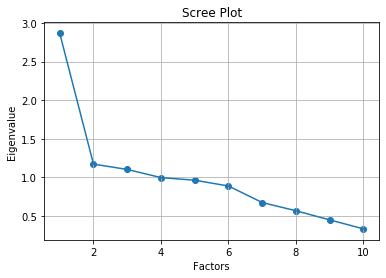

In [43]:
factor_number_tester = FactorAnalyzer(n_factors=10, rotation=None) # Using number of factors = number of columns
factor_number_tester.fit(wellness_df) 
ev, v = factor_number_tester.get_eigenvalues()

plt.scatter(range(1,wellness_df.shape[1]+1),ev)
plt.plot(range(1,wellness_df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()


It seems like we should only use one factor because the first factor has a much higher eiganvalue than the rest. The second eiganvalue is close to but above 1 meaning it could be used but using just one latent factor of wellness is convienient because it means we can use this one factor as a score for wellness in general.

### Perform Factor Analysis

In [44]:
fa = FactorAnalyzer(n_factors=1, rotation=None) # No need to perform roation when we are using 1 factor.

fa.fit(wellness_df)
fa.loadings_


array([[ 0.85904738],
       [ 0.5625984 ],
       [ 0.68571278],
       [ 0.60336224],
       [ 0.18971904],
       [ 0.58321581],
       [-0.11588916],
       [-0.15446514],
       [-0.04315373],
       [ 0.15982889]])

We see that only `Fatigue`, `Soreness`, `Desire`, `Irritability`, `SleepQuality`, and `TrainingReadiness` are significantly correlated with the single wellness factor. This might suggest that the other measures are not as nessesary.

In [45]:
fa.get_factor_variance()

(array([2.32955867]), array([0.23295587]), array([0.23295587]))

Using only one factor only explains 23% of the variance in the data which is unfortunate, however, it does stand out as having a very large eiganvalue compare to all other factors which are near or below 1 (the stadnard threshold for choosing factors)

#### Map Data To Wellness Facor

In [46]:
wellness = fa.transform(wellness_df)
wellness_df['wellness'] = wellness

wellness_df.head()

,Fatigue,Soreness,Desire,Irritability,SleepHours,SleepQuality,Pain,Illness,Menstruation,TrainingReadiness,wellness
0,3,3,2,3,8.00,2,0,0,1,0,-1.086004
1,4,3,4,4,8.00,4,1,0,1,0,0.154793
2,3,3,5,4,8.00,4,0,0,0,100,0.059101
3,2,3,5,4,6.50,1,0,0,1,95,-0.844980
4,5,3,4,4,7.25,4,0,0,0,100,0.862240


In [47]:
wellness.mean(), wellness.std()

(7.96604468519832e-17, 0.9185667738164739)

Interestingly, our new wellness score has a mean close to 0 and a standard deviation near 1, meaning it can be interpreted as a normalized wellness score.

### Factor Analysis With Trimmed Features

Recall that only `Fatigue`, `Soreness`, `Desire`, `Irritability`, `SleepQuality`, and `TrainingReadiness` were correlated with the wellness factor, we might want to train the factor analysis model on only those features.

In [48]:
trimmed_wellness_df = wellness_df.drop(columns=['SleepHours', 'Pain', 'Illness', 'Menstruation', 'wellness'])
fa.fit(trimmed_wellness_df)
ev, v = fa.get_eigenvalues()

ev

array([2.77547386, 1.05070377, 0.7542703 , 0.61644945, 0.47133699,
       0.33176564])

Without plotting another Scree plot, we see that again, we can use one factor.

In [49]:
fa.get_factor_variance()

(array([2.25834652]), array([0.37639109]), array([0.37639109]))

By cutting out uncorrelated varaibles, we are not explaining twice the variance we were before.

In [50]:
trimmed_wellness = fa.transform(trimmed_wellness_df)
trimmed_wellness_df['wellness'] = trimmed_wellness

trimmed_wellness_df.head()

,Fatigue,Soreness,Desire,Irritability,SleepQuality,TrainingReadiness,wellness
0,3,3,2,3,2,0,1.078322
1,4,3,4,4,4,0,-0.278851
2,3,3,5,4,4,100,-0.050964
3,2,3,5,4,1,95,0.738618
4,5,3,4,4,4,100,-0.861147


## Next Steps

I need to confirm if removing features from the factor analysis due to a lack of standardized correlation is appropriate. I also found that `Pain` and `TrainingReadiness` were inappropriate for factor analysis from the KMO test earlier in this notebook. Maybe I should remove these values instead of removing the features with weak correlations to the latent wellness factor.

## What I Am Still Confused About

How does rotation come into play with factor analysis?

How should I deal with the nutrition column. It has a lot of missing values. Should I ignore it altogether? I ignored it for now.